In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.path as mpath
import matplotlib.colors as col
from netCDF4 import Dataset

import xarray as xr
import xesmf as xe

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/pc5520/figures/basal_melt_param/'

In [2]:
client = Client()
client

2022-11-25 17:05:07,527 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-9hnz5bon', purging
2022-11-25 17:05:07,527 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-k19mhbrg', purging
2022-11-25 17:05:07,528 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-msdkkyvk', purging
2022-11-25 17:05:07,528 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-al56ugn3', purging
2022-11-25 17:05:07,528 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-p9qqeh9r', purging
2022-11-25 17:05:07,528 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/64799264.gadi-pbs/dask-worker-space/worker-ax21v76u', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34005,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:34123,Total threads: 4
Dashboard: /proxy/38641/status,Memory: 20.87 GiB
Nanny: tcp://127.0.0.1:42069,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
basal_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

In [4]:
master_session = cc.database.create_session()

control = '01deg_jra55v13_ryf9091'


# realistic calving + conservative temperature + tfreezing as in GPC006 / calving put in runoff array - test
Tfreezing_min_calv_2 = 'accessom2-GPC013'
# idem as GPC013 but gade line formulation
Tfreezing_min_calv_2_gade = 'accessom2-GPC015'

start_time='2152-01-01'
end_time='2153-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC013/',
           '/g/data/e14/pc5520/access-om2/archive/01deg_jra55v13_ryf9091_rerun_for_easterlies/accessom2-GPC015/']
cc.database.build_index(dir_list,basal_melt_session)

Indexing experiment: accessom2-GPC013


0it [00:00, ?it/s]


Indexing experiment: accessom2-GPC015


0it [00:00, ?it/s]


0

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

In [7]:
runoff_Tfreezing_min_calv_2 = cc.querying.getvar(Tfreezing_min_calv_2, 'runoff', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
runoff_Tfreezing_min_calv_2 = runoff_Tfreezing_min_calv_2.sum('yt_ocean').load()

In [8]:
area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)
lon = cc.querying.getvar(Tfreezing_min_calv_2, 'x', basal_melt_session, n=1)
lat = cc.querying.getvar(Tfreezing_min_calv_2, 'y', basal_melt_session, n=1)

In [9]:
import numpy as np
from netCDF4 import Dataset as nc

nc_icb_file = "/home/552/pc5520/forcing_files/ICB/Iceberg_Interannual_Merino.nc"
ncfile_icb = nc(nc_icb_file,'r')
icbflux = ncfile_icb.variables['Icb_flux'][:,:,:]
lon_icb = ncfile_icb.variables['longitude'][:,:]
lat_icb = ncfile_icb.variables['latitude'][:,:]
ncfile_icb.close()

#NEMO GRID
nemo_grid_file = "/home/552/pc5520/forcing_files/ICB/cut_ORCA025_coordinates.nc"
nemo_grid = nc(nemo_grid_file,'r')
nav_lon = nemo_grid.variables['nav_lon'][:,:]
nav_lat = nemo_grid.variables['nav_lat'][:,:]
e1t = nemo_grid.variables['e1t'][0,:,:]
e2t = nemo_grid.variables['e2t'][0,:,:]
nemo_grid.close()

In [10]:
icb_mass = icbflux * 0
for tt in range(icb_mass.shape[0]):
    icb_mass[tt,:,:] = icbflux[tt,:,:] * e1t[:,:] * e2t [:,:]

In [11]:
hgrid_path = "/home/552/pc5520/forcing_files/ICB/ocean_hgrid_simple.nc"

dg = xr.open_dataset(hgrid_path)[["x", "y"]]
dg = dg.rename({"x": "lon", "y": "lat"}).set_coords(["lon", "lat"])

In [12]:
di = xr.open_dataset("/home/552/pc5520/forcing_files/ICB/Iceberg_Interannual_Merino.nc")
di = di.rename({"longitude": "lon", "latitude": "lat"})

In [13]:
regridder = xe.Regridder(di, dg, "bilinear")

In [14]:
data_regrided = regridder(di.Icb_flux[0]*e1t*e2t)

In [15]:
data_regrided.name = "Icb_flux"

In [16]:
area_acc=area_t.load()
data=data_regrided.load()

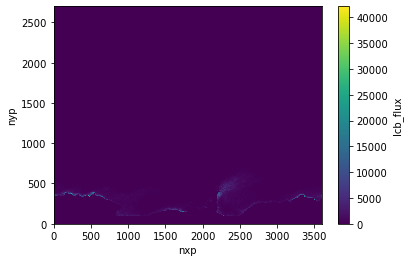

In [17]:
data_regrided.plot()

In [ ]:
fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=0,vmax=1000)
ax = fig.add_axes([0.62, 0.0, 0.27, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(data_regrided.lon, data_regrided.lat, data_regrided, norm=norm,
                   cmap = cmocean.cm.jet, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,colors='k',linewidths=1,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())